## Data figures of CNN performance

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pickle
sys.path.append('../scripts/')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio, rasterio.plot
import shapely as shp
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
import land_cover_models as lcm
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch 
import pytorch_lightning as pl
import pickle
import tabulate

from geocube.api.core import make_geocube
# import segmentation_models_pytorch as smp
lcv.set_fontsize(10)
path_dict = loadpaths.loadpaths()

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


Font size is set to 10


## Prep data for both figures:

In [3]:
df_main = lca.load_pols('../content/evaluation_polygons/landscape_character_2022_FGH-override/landscape_character_2022_FGH-override.shp')
df_detailed = lca.load_pols('../content/evaluation_polygons/landscape_character_2022_detailed_CFGH-override/landscape_character_2022_detailed_CFGH-override.shp')
df_tile_outlines = lca.load_pols('../content/evaluation_sample_50tiles/evaluation_sample_50tiles/evaluation_sample_50tiles.shp')
pol_outline = df_tile_outlines[df_tile_outlines['PLAN_NO'] == 'SK1357'].iloc[0]['geometry']
eval_patch_outlines = lca.load_pols('../content/evaluation_sample_50tiles/eval_patch_grid_annotations/eval_patch_grid_annotations.shp')
eval_patch_outlines_2 = lca.load_pols('../content/evaluation_sample_50tiles/eval_2_patch_grid_annotations/eval_2_patch_grid_annotations.shp')
eval_patch_outlines_concat = pd.concat([eval_patch_outlines, eval_patch_outlines_2], axis=0)

df_detailed = lca.test_validity_geometry_column(df_detailed)
df_detailed = df_detailed[df_detailed['Class_low'] != '0']

## Prep data for distribution plots:
dict_pols_detailed_rand = lca.get_pols_for_tiles(df_pols=df_detailed, col_name='tile_patch',
                        df_tiles=eval_patch_outlines_concat[np.logical_or(eval_patch_outlines_concat['RAND_ANNOT'] == 1, eval_patch_outlines_concat['SEL_ANNOT'] == 1)], 
                        col_ind_name='Class_low', col_class_name='Class_low')
# dict_tile_patches
dict_pols_detailed_rand = {key[:7] + 'patch' + key[8:].zfill(3): val for key, val in dict_pols_detailed_rand.items()}
dict_area_0 = {}
for tp, df in dict_pols_detailed_rand.items():
    if '0' in df['Class_low'].values:
        dict_area_0[tp] = df[df['Class_low'] == '0']['geometry'].area.sum()
    else:
        dict_area_0[tp] = 0

def map_low_to_high_level(code):
    if code == 'F3a':
        return 'D'
    elif code == 'F3d':
        return 'E'
    else:
        return code[0]
    
for key in dict_pols_detailed_rand.keys():
    dict_pols_detailed_rand[key]['Class_high'] = dict_pols_detailed_rand[key]['Class_low'].apply(map_low_to_high_level)


100%|██████████| 1028/1028 [00:04<00:00, 223.37it/s]


0 tiles were empty: []


In [4]:
dict_colour = {'train': 'grey', 'test': 'k',
               'C': '#0e8212',
                'D': '#a33b1a',
               'E': '#465E85'}
dict_labels_full = {'C': 'C - Woodlands',
                    'D': 'D - Moorlands',
                    'E': 'E - Grasslands'}
roman_numerics = ['i', 'ii', 'iii', 'iv', 'v', 'vi', 'vii', 'viii', 'ix', 'x']

## Main class figure:

In [6]:
# model_path_main = 'LCU_2023-03-26-1718.data'  # v1
model_path_main = 'LCU_2023-04-24-1259.data'  # v2
LCU_main = lcm.load_model(#folder='/media/data-hdd/gis_pd/archive_models/models', 
                          filename=model_path_main)
LCU_main.eval()

path_mapping_dict_main = LCU_main.dict_training_details['path_mapping_dict']
with open(LCU_main.dict_training_details['tile_patch_train_test_split_dict_path'], 'rb') as f:
            dict_tile_patches = pickle.load(f)
            tile_patch_train = dict_tile_patches['train']
            tile_patch_test = dict_tile_patches['test']
# dir_test_im_patches = ['/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/images_detailed_annotation/',
                            # '/home/tplas/data/gis/most recent APGB 12.5cm aerial/eval_2_tiles/images_detailed_annotation/']  # v1 

dir_test_im_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/eval_all_tiles/images_detailed_annotation/'
mask_suffix_test_ds = '_lc_2022_detailed_mask.npy'
       
test_ds_main = lcm.DataSetPatches(im_dir=dir_test_im_patches, mask_dir=None, 
                            mask_suffix=mask_suffix_test_ds, mask_dir_name='masks_detailed_annotation',
                            preprocessing_func=LCU_main.preprocessing_func, 
                            shuffle_order_patches=False, relabel_masks=True,
                            subsample_patches=False,
                            list_tile_patches_use=tile_patch_test,
                            path_mapping_dict=path_mapping_dict_main)
test_ds_main.remove_no_class_patches()

Loaded LCU_2023-04-24-1259
loss_function is cross_entropy
n_max_epochs is 60
LandCoverUNet class using CrossEntropyLoss()
main_categories_F3inDE_noFGH training using randomly split eval patch data. cross_entropy resnet50 60 epochs
No mask directory provided. Will use masks_detailed_annotation/ in image parent directory instead.
Only using patches that are in tile_patches list (of length 308).
Patches sorted by tile/patch order
Loaded 308 patches
Loaded label_mapping_dict__main_categories_F3inDE_noFGH__2023-04-21-1315.pkl to map labels


100%|██████████| 308/308 [00:01<00:00, 220.76it/s]

Removed 1 patches with no class


In [11]:
# lcv.get_lc_colour_mapping()[2]
test_ds_main.class_name_list,

(['NO CLASS',
  'Wood and Forest Land',
  'Moor and Heath Land',
  'Agro-Pastoral Land'],)

Removing NO CLASS from confusion matrix


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


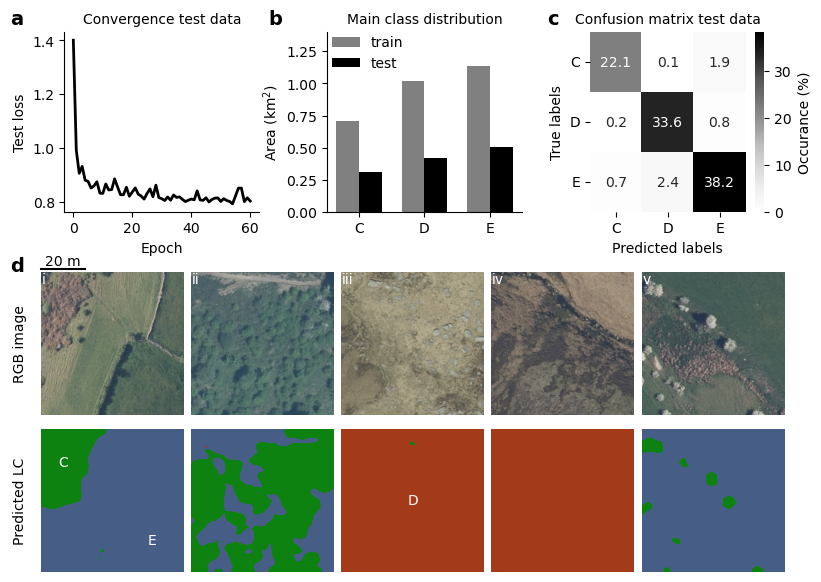

In [20]:
save_fig = True

fig = plt.figure(figsize=(8, 6), constrained_layout=False)
gs_data = fig.add_gridspec(1, 3, wspace=0.35, hspace=0.3, left=0.05, right=0.95, top=0.95, bottom=0.65)
# names_examples = ['SK0684_patch138', 'SK1871_patch167', 'SK0752_patch049', 
#                   'SK0988_patch028', 'SK0682_patch163']
# names_examples = ['SK1154_patch181', 'SK0956_patch087', 'SK0752_patch049', 
#                 #   'SJ9772_patch002', 
#                   'SK0896_patch171',
#                   'SE1400_patch200']
names_examples = ['SK0956_patch081', 
                  'SK0879_patch034',
                  'SK0988_patch028', 
                        'SK2096_patch129',
                        'SK0752_patch049']
# inds_examples = [10, 26, 39, 40, 77]  # either specify the indices or the names
inds_examples = [int(np.where(test_ds_main.df_patches['patch_name'] == x)[0][0]) for x in names_examples]

n_examples = len(inds_examples)
add_cbar = False
gs_ims = fig.add_gridspec(2, n_examples, wspace=0.05, hspace=0.1, left=0.02, right=0.75 if add_cbar else 0.95, 
                          top=0.55, bottom=0.05)
if add_cbar:
    gs_cbar = fig.add_gridspec(1, 1, left=0.9, right=0.92, top=0.55, bottom=0.05)
    ax_cbar = fig.add_subplot(gs_cbar[0])
else:
    ax_cbar = None

ax_conv = fig.add_subplot(gs_data[ 0])
# lcv.plot_convergence_model(model=LCU, ax=ax_conv, metric='train_loss', colour_line=dict_colour['train'])
lcv.plot_convergence_model(model=LCU_main, ax=ax_conv, metric='val_loss', colour_line=dict_colour['test'])
ax_conv.set_title('Convergence test data')

ax_distr = fig.add_subplot(gs_data[1])
ax_distr, main_class_name_list = lcv.plot_distribution_train_test_classes(dict_pols_per_patch=dict_pols_detailed_rand, 
                                         plot_dual_axis=False, colour_dict=dict_colour,
                                         ax=ax_distr, dict_train_test_split=dict_tile_patches,
                                         col_name_class='Class_high', rotation_xticklabels=0)
ax_distr.set_title('Main class distribution')
ax_distr.set_ylim([0, 1.4])
lcv.despine(ax_distr)
ax_distr.legend(loc='upper left', bbox_to_anchor=(-0.04, 1.05), frameon=False)

ax_conf = fig.add_subplot(gs_data[2])
tmp = lcv.plot_confusion_summary(model=LCU_main, normalise_hm=True, ax_hm=ax_conf,
                               fmt_annot='.1f', print_table=False)
df_stats_main_classes = tmp[0]
ax_conf.set_title('Confusion matrix test data')

ax_ims = []
ax_lcs = []
for i in range(n_examples):
    ax_ims.append(fig.add_subplot(gs_ims[0, i]))
    ax_lcs.append(fig.add_subplot(gs_ims[1, i]))
assert len(inds_examples) == n_examples
batch, patch_names = lcm.get_any_combination_from_ds(ds=test_ds_main, list_inds=inds_examples)
predicted_labels = LCU_main.forward(batch[0])
predicted_labels = lca.change_tensor_to_max_class_prediction(pred=predicted_labels)
## undo preprocessing of image so the true RGB image is shown again:
ims_plot = lca.undo_zscore_single_image(im_ds=batch[0], f_preprocess=test_ds_main.preprocessing_func)
ims_plot = ims_plot.detach().numpy()
for i in range(n_examples):
    lcv.plot_image_simple(im=ims_plot[i, :, :, :], ax=ax_ims[i])
    lcv.plot_landcover_image(im=predicted_labels[i, :, :], ax=ax_lcs[i], 
                            lc_class_name_list=test_ds_main.class_name_list, 
                            unique_labels_array=test_ds_main.unique_labels_arr,
                            plot_colorbar=True if i == (n_examples - 1) and add_cbar else False, 
                            cax=ax_cbar)
    ax_ims[i].text(s=roman_numerics[i], x=2, y=2, ha='left', va='top', c='w')
    
ax_ims[0].set_ylabel('RGB image')
ax_lcs[0].set_ylabel('Predicted LC')

fig.align_ylabels([ax_conv, ax_ims[0], ax_lcs[0]])
## Plot scale bar:
xlims = ax_ims[0].get_xlim()
ylims = ax_ims[0].get_ylim()
ax_ims[0].plot([0, 512 / 64 * 20], [-10, -10], c='k', clip_on=False)
ax_ims[0].text(s='20 m', x=80, y=-12, ha='center', va='bottom', clip_on=False)
ax_ims[0].set_xlim(xlims)
ax_ims[0].set_ylim(ylims)

## LC labels:
ax_lcs[0].text(s='C', x=80, y=120, ha='center', va='center', zorder=5, c='w')
ax_lcs[0].text(s='E', x=400, y=400, ha='center', va='center', zorder=5, c='w')
ax_lcs[2].text(s='D', x=256, y=256, ha='center', va='center', zorder=5, c='w')

## Panel labels:
ax_conv.text(s='a', x=-0.28, y=1.02, ha='left', va='bottom', transform=ax_conv.transAxes, fontweight='bold', fontsize=14, clip_on=False)
ax_conv.text(s='b', x=1.05, y=1.02, ha='left', va='bottom', transform=ax_conv.transAxes, fontweight='bold', fontsize=14, clip_on=False)
ax_conv.text(s='c', x=2.48, y=1.02, ha='left', va='bottom', transform=ax_conv.transAxes, fontweight='bold', fontsize=14, clip_on=False)
ax_conv.text(s='d', x=-0.28, y=-0.35, ha='left', va='bottom', transform=ax_conv.transAxes, fontweight='bold', fontsize=14, clip_on=False)

if save_fig:
    plt.savefig('../figures/fig_mainclass_stats.pdf', dpi=300, bbox_inches='tight')

In [9]:
## rename column name:
df_stats_main_classes = df_stats_main_classes.rename(columns={'class shortcut': 'Code',
                                                                          'true density': 'Density test set'})
df_stats_main_classes['Classifier'] = 'Main'
## sort by code:
df_stats_main_classes = df_stats_main_classes.sort_values(by='Code')
# ## drop columns:
df_stats_main_classes = df_stats_main_classes.drop(columns=['predicted density'])


## Mapping accuracy: 
def mapping_accuracy(df_stats_main_classes, df_main, model, 
                     skip_zero_class=True, class_name_list=[]):
    df_stats_main_classes = df_stats_main_classes.copy()
    df_main = df_main.copy()

    df_main['area'] = df_main['geometry'].area
    df_main_sum = df_main.groupby('Class_high').sum()
    ## set index as col
    df_main_sum['density'] = df_main_sum['area'] / df_main_sum['area'].sum()
    print(df_main_sum)
    conf_mat = model.test_confusion_mat 
    conf_mat = conf_mat.copy()
    if skip_zero_class:
        conf_mat = conf_mat[1:, 1:]
    assert len(class_name_list) == conf_mat.shape[0], f'Lenght: {len(class_name_list)} != {conf_mat.shape[0]}'
    for i, class_label in enumerate(class_name_list):
        conf_mat[i, :] = conf_mat[i, :] / df_stats_main_classes.loc[df_stats_main_classes['Code'] == class_label, 'Density test set'].values[0]
        conf_mat[i, :] = conf_mat[i, :] * df_main_sum.loc[class_label, 'density']
    classes_not_pred = [x for x in df_main_sum.index if x not in class_name_list]
    mat_not_pred = np.zeros((len(classes_not_pred), len(classes_not_pred)))
    for i, class_label in enumerate(classes_not_pred):
        mat_not_pred[i, i] = df_main_sum.loc[class_label, 'density']

    conf_mat = conf_mat / conf_mat.sum()
    total_density_pred = df_main_sum.loc[df_main_sum.index.isin(class_name_list), 'density'].sum()
    conf_mat = conf_mat * total_density_pred

    total_conf_mat  = np.zeros((len(df_main_sum), len(df_main_sum)))
    total_conf_mat[0:len(class_name_list), 0:len(class_name_list)] = conf_mat
    total_conf_mat[len(class_name_list):, len(class_name_list):] = mat_not_pred

    return total_conf_mat

tmp  = mapping_accuracy(df_stats_main_classes, df_main, LCU_main,
                 skip_zero_class=True, class_name_list=main_class_name_list)
print(f'Mapping accuracy: {tmp.diagonal().sum() / tmp.sum()}')
df_stats_main_classes

             pol_id          area   density
Class_high                                 
C             96473  2.354826e+06  0.047608
D             32073  2.063670e+07  0.417217
E            262554  2.414452e+07  0.488135
F             29764  2.875429e+05  0.005813
G             10828  3.590833e+04  0.000726
H           1241281  2.003258e+06  0.040500
Mapping accuracy: 0.9474484771842475


,class name,Code,sensitivity,precision,Density test set,Classifier
0,Wood and Forest Land,C,0.914396,0.960664,0.241534,Main
1,Moor and Heath Land,D,0.971359,0.930207,0.345703,Main
2,Agro-Pastoral Land,E,0.925171,0.933451,0.412763,Main


In [10]:
lca.export_df_stats_to_latex(df_stats_main_classes, path_latex='../figures/tables/df_stats_per_main_class.tex')

Index(['class name', 'Code', 'sensitivity', 'precision', 'Density test set',
       'Classifier'],
      dtype='object')


,\textbf{Class name},\textbf{Code},\textbf{Sensitivity},\textbf{Precision},\textbf{Density test set},\textbf{Classifier}
0,Wood and Forest Land,C,0.91,0.96,24.2\%,Main
1,Moor and Heath Land,D,0.97,0.93,34.6\%,Main
2,Agro-Pastoral Land,E,0.93,0.93,41.3\%,Main


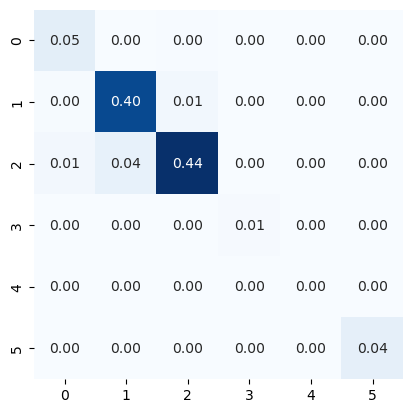

In [9]:
sns.heatmap(tmp, annot=True, fmt='.2f', cmap='Blues', cbar=False, square=True,)

In [10]:
df_main.groupby('Class_high').sum()

,pol_id
Class_high,
C,96473
D,32073
E,262554
F,29764
G,10828
H,1241281


## Detailed class figure:

In [7]:
model_path_det = {'C': 'LCU_2023-04-21-1335.data',
                  'D': 'LCU_2023-04-25-2057.data',
                  'E': 'LCU_2023-04-24-1216.data'}

dir_test_im_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/eval_all_tiles/images_detailed_annotation/'

# dir_test_im_patches = ['/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/images_detailed_annotation/',
#                             '/home/tplas/data/gis/most recent APGB 12.5cm aerial/eval_2_tiles/images_detailed_annotation/']
mask_suffix_test_ds = '_lc_2022_detailed_mask.npy'

LCU_det = {}
path_mapping_det = {}
test_ds_det = {}
dict_class_names = {}
for key, val in model_path_det.items():
    LCU_det[key] = lcm.load_model(#folder='/media/data-hdd/gis_pd/archive_models/models/', 
                                  filename=val)
    LCU_det[key].eval()

    with open(LCU_det[key].dict_training_details['tile_patch_train_test_split_dict_path'], 'rb') as f:
                dict_tile_patches_tmp = pickle.load(f)
                tile_patch_test_tmp = dict_tile_patches_tmp['test']
                assert (tile_patch_test == tile_patch_test_tmp), 'Test tiles are not the same for all models!'

    path_mapping_det[key] = LCU_det[key].dict_training_details['path_mapping_dict']

       
    test_ds_det[key] = lcm.DataSetPatches(im_dir=dir_test_im_patches, mask_dir=None, 
                                mask_suffix=mask_suffix_test_ds, mask_dir_name='masks_detailed_annotation',
                                preprocessing_func=LCU_det[key].preprocessing_func, 
                                shuffle_order_patches=False, relabel_masks=True,
                                subsample_patches=False,
                                list_tile_patches_use=tile_patch_test,
                                path_mapping_dict=path_mapping_det[key])
    test_ds_det[key].remove_no_class_patches()
    dict_class_names[key] = test_ds_det[key].class_name_list

test_ds_det['all'] = test_ds_main

Loaded LCU_2023-04-21-1335
loss_function is cross_entropy
n_max_epochs is 60
LandCoverUNet class using CrossEntropyLoss()
C_subclasses_only training using randomly split eval patch data. cross_entropy resnet50 60 epochs
No mask directory provided. Will use masks_detailed_annotation/ in image parent directory instead.
Only using patches that are in tile_patches list (of length 308).
Patches sorted by tile/patch order
Loaded 308 patches
Loaded label_mapping_dict__C_subclasses_only__2023-04-20-1540.pkl to map labels


100%|██████████| 308/308 [00:00<00:00, 328.72it/s]


Removed 186 patches with no class
Loaded LCU_2023-04-25-2057
loss_function is cross_entropy
n_max_epochs is 60
LandCoverUNet class using CrossEntropyLoss()
D_subclasses_only training using randomly split eval patch data. cross_entropy resnet50 60 epochs
No mask directory provided. Will use masks_detailed_annotation/ in image parent directory instead.
Only using patches that are in tile_patches list (of length 308).
Patches sorted by tile/patch order
Loaded 308 patches
Loaded label_mapping_dict__D_subclasses_only__2023-04-20-1540.pkl to map labels


100%|██████████| 308/308 [00:00<00:00, 324.43it/s]


Removed 174 patches with no class
Loaded LCU_2023-04-24-1216
loss_function is cross_entropy
n_max_epochs is 60
LandCoverUNet class using CrossEntropyLoss()
E_subclasses_and_F3d_only training using randomly split eval patch data. cross_entropy resnet50 60 epochs
No mask directory provided. Will use masks_detailed_annotation/ in image parent directory instead.
Only using patches that are in tile_patches list (of length 308).
Patches sorted by tile/patch order
Loaded 308 patches
Loaded label_mapping_dict__E_subclasses_and_F3d_only__2023-04-20-1541.pkl to map labels


100%|██████████| 308/308 [00:01<00:00, 296.42it/s]

Removed 150 patches with no class


In [8]:
df_patches_only_concat = pd.concat(list(dict_pols_detailed_rand.values()))
unique_classes = df_patches_only_concat['Class_low'].unique()

unique_classes

array(['D6c', '0', 'F3a', 'D2d', 'F3d', 'D7a', 'D1a', 'E2b', 'G2', 'H2a',
       'H1b', 'H3b', 'E2a', 'C1', 'H', 'H1a', 'C4', 'C2', 'C5', 'C', 'C3',
       'F2', 'D3', 'D6b', 'D2b'], dtype=object)

{'train': {'C1': 0.34605045459561534, 'C2': 0.20745397018664144, 'C4': 0.05016957134784004, 'C5': 0.10073649379258695, 'D1a': 0.2516040128365688, 'D2d': 0.28231998855470375, 'D3': 0.07835824486575588, 'D6c': 0.21353381493857573, 'E2a': 0.7204791431254279, 'E2b': 0.3233881363697409, 'F3a': 0.160180168113212, 'F3d': 0.0920618468400307}, 'test': {'C1': 0.13617760168757828, 'C2': 0.11892575158103655, 'C4': 0.020967482339198616, 'C5': 0.03284152382703668, 'D1a': 0.130113522123876, 'D2d': 0.10872824943779151, 'D3': 0.0393753561245921, 'D6c': 0.056940396175923974, 'E2a': 0.32509371037736107, 'E2b': 0.12756502139292653, 'F3a': 0.0757130464558845, 'F3d': 0.04977620771579051}}


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


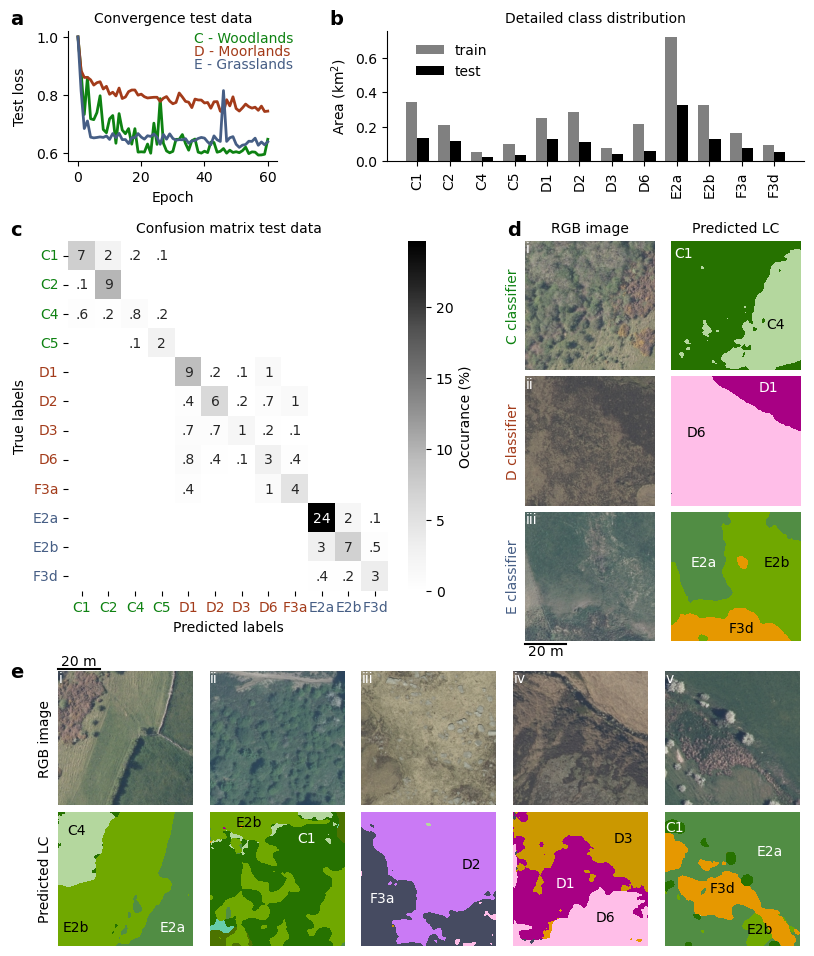

In [16]:
save_fig = True

fig = plt.figure(figsize=(8, 10), constrained_layout=False)
gs_data = fig.add_gridspec(1, 2, wspace=0.35, hspace=0.3, left=0.05, right=0.97, top=0.95, bottom=0.82, width_ratios=[1, 2])
gs_conf = fig.add_gridspec(1, 1, left=0.05, right=0.55, top=0.74, bottom=0.39)

add_cbar = False
gs_ims_1 = fig.add_gridspec(2, 5, wspace=0.05, hspace=0.05, left=0.03, right=0.75 if add_cbar else 0.97, 
                          top=0.31, bottom=0.035)
gs_ims_2 = fig.add_gridspec(3, 2, wspace=0.05, hspace=0.05, left=0.615, right=0.97, 
                          top=0.74, bottom=0.34)
if add_cbar:
    gs_cbar = fig.add_gridspec(1, 1, left=0.9, right=0.92, top=0.55, bottom=0.05)
    ax_cbar = fig.add_subplot(gs_cbar[0])
else:
    ax_cbar = None

ax_conv = fig.add_subplot(gs_data[ 0])
for key, val in LCU_det.items():
    lcv.plot_convergence_model(model=val, ax=ax_conv, metric='val_loss', colour_line=dict_colour[key], normalise=True)
# lcv.plot_convergence_model(model=LCU_main, ax=ax_conv, metric='val_loss', colour_line=dict_colour['test'])
ax_conv.set_title('Convergence test data')
# ax_conv.text(0.5, 0.9, 'Fix different loss fucntions', transform=ax_conv.transAxes, ha='center', va='center', fontsize=12)
# 'Wood and Forest Land',
#   'Moor and Heath Land',
#   'Agro-Pastoral Land'
for i_lab, label in enumerate(['C', 'D', 'E']):
    ax_conv.text(0.6, 1 - 0.1 * i_lab, dict_labels_full[label], transform=ax_conv.transAxes, 
                 ha='left', va='top', color=dict_colour[label])

ax_distr = fig.add_subplot(gs_data[1])
ax_distr, classes_plot = lcv.plot_distribution_train_test_classes(dict_pols_per_patch=dict_pols_detailed_rand, 
                                         plot_dual_axis=False, colour_dict=dict_colour,
                                         ax=ax_distr, dict_train_test_split=dict_tile_patches,
                                         col_name_class='Class_low', rotation_xticklabels=90,
                                         classes_ignore=['0', 'C3', 'D2b', 'D6b', 'D7a', 'F2', 'F', 'G', 'G2', 
                                                         'H', 'H1a', 'H1b', 'H2a', 'H2b', 'H3a', 'H3b'],
                                         class_codes_override={'D1a': 'D1', 'D2d': 'D2', 'D6c': 'D6'})
ax_distr.set_title('Detailed class distribution')
lcv.despine(ax_distr)
ax_distr.legend(loc='upper left', bbox_to_anchor=(0.04, 1.0), frameon=False)

## prep conf mat of all models
mapping_name_to_code = lca.get_mapping_class_names_to_shortcut()[1]
mapping_name_to_code['Scrub'] = 'C4'
dict_conf_mats = {} 
total_class_name_list = []
assert len(set(classes_plot)) == len(classes_plot)
for key, model in LCU_det.items():
    conf_mat = model.test_confusion_mat 
    class_name_list = model.dict_training_details['class_name_list']
    assert conf_mat.ndim == 2 and conf_mat.shape[0] == conf_mat.shape[1] and conf_mat.shape[0] == len(class_name_list)
    if key == 'D' and 'F3d' in classes_plot:
        classes_plot = [x for x in classes_plot if x != 'F3d']
    elif key == 'E' and 'F3d' not in classes_plot:
        classes_plot = classes_plot + ['F3d']
    inds_keep = np.array([mapping_name_to_code[x] in classes_plot for x in class_name_list])
    conf_mat = conf_mat[inds_keep, :][:, inds_keep]
    class_name_list = [x for i, x in enumerate(class_name_list) if inds_keep[i]]
    total_class_name_list += class_name_list
    dict_conf_mats[key] = conf_mat

assert len(set(total_class_name_list)) == len(total_class_name_list)
assert set([mapping_name_to_code[x] for x in total_class_name_list]) == set(classes_plot), f'{[mapping_name_to_code[x] for x in total_class_name_list]} vs {classes_plot}'

total_conf_mat = np.zeros((len(classes_plot), len(classes_plot)))
start_ind = 0
n_classes_per_classifier = {}
for key, conf_mat in dict_conf_mats.items():
    n_classes_per_classifier[key] = conf_mat.shape[0]
    total_conf_mat[start_ind:(start_ind + n_classes_per_classifier[key]), :][:, start_ind:(start_ind + n_classes_per_classifier[key])] = conf_mat
    start_ind += n_classes_per_classifier[key]

ax_conf = fig.add_subplot(gs_conf[0])
tmp = lcv.plot_confusion_summary(conf_mat=total_conf_mat, normalise_hm=True, ax_hm=ax_conf,
                               class_name_list=total_class_name_list,
                               dict_override_shortcuts={'Scrub': 'C4', 'Upland Heath': 'D1', 'Blanket Peat Grass Moor': 'D2', 
                                                          'Upland Heath/Blanket Peat Mosaic': 'D6'},
                               fmt_annot='.1f', print_table=False, suppress_zero_annot=True)
df_stats_per_detailed_class = tmp[0]
ax_conf.set_title('Confusion matrix test data')
start_ind = 0
for key, n_classes_tmp in n_classes_per_classifier.items():
    plt.setp(ax_conf.get_xticklabels()[start_ind:(start_ind + n_classes_tmp)], color=dict_colour[key])
    plt.setp(ax_conf.get_yticklabels()[start_ind:(start_ind + n_classes_tmp)], color=dict_colour[key])
    start_ind += n_classes_tmp
ax_ims = []
ax_lcs = []
for i in range(8):
    if i < 5:
        ax_ims.append(fig.add_subplot(gs_ims_1[0, i]))
        ax_lcs.append(fig.add_subplot(gs_ims_1[1, i]))
        ax_ims[i].text(s=roman_numerics[i], x=2, y=2, ha='left', va='top', c='w')
    else:
        ax_ims.append(fig.add_subplot(gs_ims_2[i-5, 0]))
        ax_lcs.append(fig.add_subplot(gs_ims_2[i-5, 1]))
        ax_ims[i].text(s=roman_numerics[i - 5], x=2, y=2, ha='left', va='top', c='w')

    ax_ims[i].set_xticks([])
    ax_ims[i].set_yticks([])
    ax_lcs[i].set_xticks([])
    ax_lcs[i].set_yticks([])

## plot some examples
## C: SK1091_patch051, SK2496_patch029 
## D: SK0686_patch175, SK0790_patch008, SK0790_patch066, patch_SK0790_patch089, SK0987_patch085, SK1588_patch110
## E: SJ9722_patch002, SK0682_patch063, SK1258_patch191, SK1357_patch097
dict_examples = {'C': ['SK0956_patch080'], #['SK1154_patch210'],
                 'D': ['SK0790_patch008'],  #['SK1588_patch110'],
                 'E': ['SJ9772_patch002'], #['['SK1258_patch191'],
                 'all': [# 'SK0956_patch087',
                          'SK0956_patch081', 
                  'SK0879_patch034',
                  'SK0988_patch028', 
                        'SK2096_patch129',
                        'SK0752_patch049']}
#  'SK1082_patch124',
#  'SK1091_patch051',
#  'SK1091_patch087',
#  'SK1091_patch144']}
dict_ax_inds = {'C': [5],
                'D': [6],
                'E': [7],
                'all': [0, 1, 2, 3, 4]}
# assert len(list(dict_examples.values()).join()) == 8

for key, names_examples in dict_examples.items():
    inds_examples = [int(np.where(test_ds_det[key].df_patches['patch_name'] == x)[0][0]) for x in names_examples]
    batch, patch_names = lcm.get_any_combination_from_ds(ds=test_ds_det[key], list_inds=inds_examples)
    if key == 'all':
        predicted_labels, class_name_list_plot = lcm.two_stage_patch_prediction(model_main=LCU_main, 
                                                                                dict_models_detailed=LCU_det, 
                                            batch_im=batch[0], dict_class_names_detailed=dict_class_names)
    else:
        predicted_labels = LCU_det[key].forward(batch[0])
        predicted_labels = lca.change_tensor_to_max_class_prediction(pred=predicted_labels)
        class_name_list_plot = test_ds_det[key].class_name_list
    ## undo preprocessing of image so the true RGB image is shown again:
    ims_plot = lca.undo_zscore_single_image(im_ds=batch[0], f_preprocess=test_ds_det[key].preprocessing_func)
    ims_plot = ims_plot.detach().numpy()
    for i in range(len(inds_examples)):
        ind_ax = dict_ax_inds[key][i]
        lcv.plot_image_simple(im=ims_plot[i, :, :, :], ax=ax_ims[ind_ax])
        lcv.plot_landcover_image(im=predicted_labels[i, :, :], ax=ax_lcs[ind_ax], 
                                lc_class_name_list=class_name_list_plot, 
                                unique_labels_array=test_ds_det[key].unique_labels_arr,
                                plot_colorbar=False, 
                                cax=ax_cbar)
        
ax_ims[0].set_ylabel('RGB image')
ax_lcs[0].set_ylabel('Predicted LC')
ax_ims[5].set_ylabel('C classifier', color=dict_colour['C'])
ax_ims[6].set_ylabel('D classifier', color=dict_colour['D'])
ax_ims[7].set_ylabel('E classifier', color=dict_colour['E'])
ax_ims[5].set_title('RGB image')
ax_lcs[5].set_title('Predicted LC')

fig.align_ylabels([ax_conv, ax_conf]) # , ax_ims[0], ax_lcs[0]

## Plot scale bar:
for i_plot in [0, 7]:
    if i_plot == 0:
        y_bar = -10
        y_text = -12
    elif i_plot == 7:
        y_bar = 512 + 10
        y_text = 512 + 14
    xlims = ax_ims[i_plot].get_xlim()
    ylims = ax_ims[i_plot].get_ylim()
    ax_ims[i_plot].plot([0, 512 / 64 * 20], [y_bar, y_bar], c='k', clip_on=False)
    ax_ims[i_plot].text(s='20 m', x=80, y=y_text, ha='center', va='bottom' if i_plot == 0 else 'top', clip_on=False)
    ax_ims[i_plot].set_xlim(xlims)
    ax_ims[i_plot].set_ylim(ylims)

## LC labels:
ax_lcs[5].text(s='C4', x=380, y=330, ha='left', va='center', zorder=5, c='k')
ax_lcs[5].text(s='C1', x=50, y=50, ha='center', va='center', zorder=5, c='w')
ax_lcs[6].text(s='D1', x=350, y=70, ha='left', va='bottom', zorder=5, c='w', clip_on=False)
ax_lcs[6].text(s='D6', x=100, y=250, ha='center', va='bottom', zorder=5, c='k')
ax_lcs[7].text(s='E2a', x=130, y=200, ha='center', va='center', zorder=5, c='w')
ax_lcs[7].text(s='E2b', x=420, y=200, ha='center', va='center', zorder=5, c='k', clip_on=False)
ax_lcs[7].text(s='F3d', x=280, y=460, ha='center', va='center', zorder=5, c='k', clip_on=False)


ax_lcs[0].text(s='E2a', x=440, y=440, ha='center', va='center', zorder=5, c='w')
ax_lcs[0].text(s='E2b', x=70, y=440, ha='center', va='center', zorder=5, c='k', clip_on=False)
ax_lcs[0].text(s='C4', x=70, y=70, ha='center', va='center', zorder=5, c='k')


ax_lcs[1].text(s='E2b', x=150, y=40, ha='center', va='center', zorder=5, c='k')
ax_lcs[1].text(s='C1', x=370, y=100, ha='center', va='center', zorder=5, c='w')

ax_lcs[2].text(s='D2', x=420, y=200, ha='center', va='center', zorder=5, c='k', clip_on=False)
ax_lcs[2].text(s='F3a', x=80, y=330, ha='center', va='center', zorder=5, c='w')

ax_lcs[3].text(s='D3', x=420, y=100, ha='center', va='center', zorder=5, c='k')
ax_lcs[3].text(s='D1', x=160, y=300, ha='left', va='bottom', zorder=5, c='w', clip_on=False)
ax_lcs[3].text(s='D6', x=350, y=430, ha='center', va='bottom', zorder=5, c='k')

ax_lcs[4].text(s='E2a', x=400, y=150, ha='center', va='center', zorder=5, c='w')
ax_lcs[4].text(s='F3d', x=220, y=290, ha='center', va='center', zorder=5, c='k', clip_on=False)
ax_lcs[4].text(s='E2b', x=360, y=450, ha='center', va='center', zorder=5, c='k', clip_on=False)
ax_lcs[4].text(s='C1', x=2, y=60, ha='left', va='center', zorder=5, c='w', clip_on=False)


## Panel labels:
ax_conv.text(s='a', x=-0.28, y=1.02, ha='left', va='bottom', transform=ax_conv.transAxes, fontweight='bold', fontsize=14, clip_on=False)
ax_conv.text(s='b', x=1.25, y=1.02, ha='left', va='bottom', transform=ax_conv.transAxes, fontweight='bold', fontsize=14, clip_on=False)
ax_conv.text(s='c', x=-0.28, y=-0.6, ha='left', va='bottom', transform=ax_conv.transAxes, fontweight='bold', fontsize=14, clip_on=False)
ax_conv.text(s='d', x=2.1, y=-0.6, ha='left', va='bottom', transform=ax_conv.transAxes, fontweight='bold', fontsize=14, clip_on=False)
ax_conv.text(s='e', x=-0.28, y=-4.00, ha='left', va='bottom', transform=ax_conv.transAxes, fontweight='bold', fontsize=14, clip_on=False)

if save_fig:
    plt.savefig('../figures/fig_detailedclass_stats.pdf', dpi=300, bbox_inches='tight')

In [20]:
## rename column name:
df_stats_per_detailed_class = df_stats_per_detailed_class.rename(columns={'class shortcut': 'Code',
                                                                          'true density': 'Density test set'})
df_stats_per_detailed_class['Classifier'] = 'C'
df_stats_per_detailed_class.loc[df_stats_per_detailed_class['Code'].str.contains('D'), 'Classifier'] = 'D'
df_stats_per_detailed_class.loc[df_stats_per_detailed_class['Code'].str.contains('E'), 'Classifier'] = 'E'
df_stats_per_detailed_class.loc[df_stats_per_detailed_class['Code'] == 'F3a', 'Classifier'] = 'D'
df_stats_per_detailed_class.loc[df_stats_per_detailed_class['Code'] == 'F3d', 'Classifier'] = 'E'
## sort by code:
df_stats_per_detailed_class = df_stats_per_detailed_class.sort_values(by='Code')
## drop columns:
df_stats_per_detailed_class = df_stats_per_detailed_class.drop(columns=['predicted density'])
df_stats_per_detailed_class

,class name,Code,sensitivity,precision,Density test set,Classifier
0,Broadleaved High Forest,C1,0.730325,0.915605,0.099485,C
1,Coniferous High Forest,C2,0.989107,0.784612,0.098880,C
2,Scrub,C4,0.461280,0.773876,0.017434,C
3,Clear Felled/New Plantings in Forest Areas,C5,0.963738,0.916666,0.027306,C
4,Upland Heath,D1a,0.839783,0.800651,0.108004,D
5,Blanket Peat Grass Moor,D2d,0.704312,0.822380,0.087779,D
6,Bracken,D3,0.519910,0.827729,0.036258,D
7,Upland Heath/Blanket Peat Mosaic,D6c,0.640796,0.475490,0.046454,D
9,Improved Pasture,E2a,0.920679,0.878630,0.268013,E
10,Rough Pasture,E2b,0.671827,0.760778,0.106048,E


In [21]:
lca.export_df_stats_to_latex(df_stats_per_detailed_class, path_latex='../figures/tables/df_stats_per_detailed_class.tex')

Index(['class name', 'Code', 'sensitivity', 'precision', 'Density test set',
       'Classifier'],
      dtype='object')


,\textbf{Class name},\textbf{Code},\textbf{Sensitivity},\textbf{Precision},\textbf{Density test set},\textbf{Classifier}
0,Broadleaved High Forest,C1,0.73,0.92,9.9\%,C
1,Coniferous High Forest,C2,0.99,0.78,9.9\%,C
2,Scrub,C4,0.46,0.77,1.7\%,C
3,Clear Felled/New Plantings in Forest Areas,C5,0.96,0.92,2.7\%,C
4,Upland Heath,D1a,0.84,0.80,10.8\%,D
5,Blanket Peat Grass Moor,D2d,0.70,0.82,8.8\%,D
6,Bracken,D3,0.52,0.83,3.6\%,D
7,Upland Heath/Blanket Peat Mosaic,D6c,0.64,0.48,4.6\%,D
9,Improved Pasture,E2a,0.92,0.88,26.8\%,E
10,Rough Pasture,E2b,0.67,0.76,10.6\%,E


## bits & pieces

In [37]:
total_class_name_list, conf_mat.shape

(['Broadleaved High Forest',
  'Coniferous High Forest',
  'Mixed High Forest',
  'Scrub',
  'Clear Felled/New Plantings in Forest Areas',
  'Upland Heath',
  'Upland Grass Moor',
  'Blanket Peat Grass Moor',
  'Bracken',
  'Upland Heath/Bracken Mosaic',
  'Upland Heath/Blanket Peat Mosaic',
  'Eroded Bare Peat',
  'Wetland, Peat Bog',
  'Improved Pasture',
  'Rough Pasture',
  'Wetland, Wet Grassland and Rush Pasture'],
 (8, 8))

adding scrub
adding wetland
adding transport


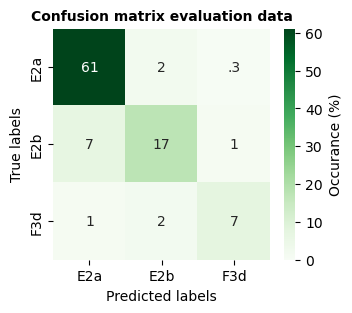

In [62]:
fig, ax_hm = plt.subplots(1, 1, figsize=(3.5, 3))
conf_mat = LCU_det['E'].test_confusion_mat
# axes_keep = np.array([1, 2, 4, 7])
# axes_keep = np.array([1, 2, 3, 4, 8, 9, 10, 13, 14])
axes_keep = np.array([2, 3, 4])
conf_mat = conf_mat[axes_keep, :][:, axes_keep]
_ = lcv.plot_confusion_summary(#model=LCU_det['E'], 
                               conf_mat=conf_mat, ax_hm=ax_hm,
                               normalise_hm=True, text_under_mat=True,
                               fmt_annot='.1f', print_table=False, suppress_zero_annot=True,
                               class_name_list=total_class_name_list[-3:])

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


276


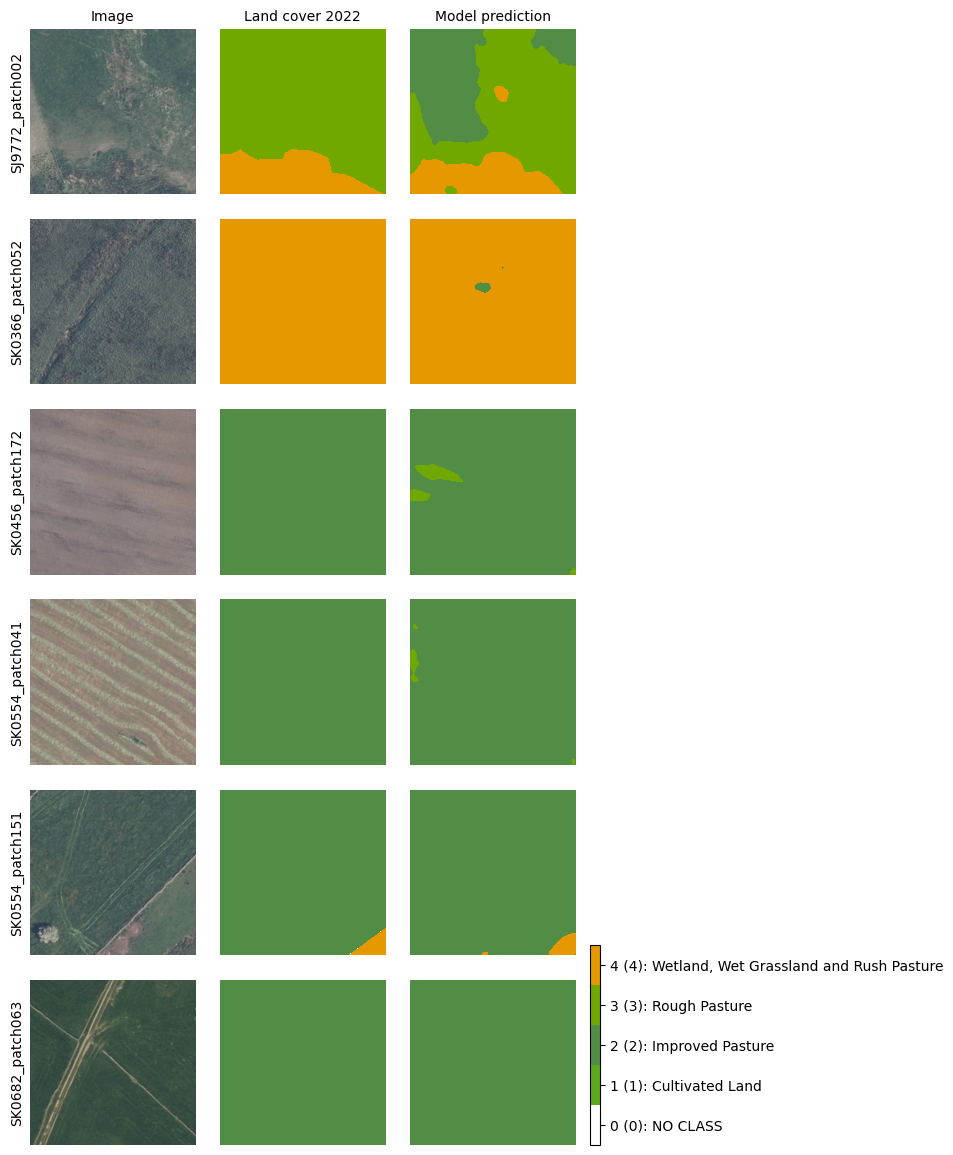

In [186]:
kk += 4
# kk = 0
key = 'E'
# inds_examples_c = [51] #[12, 20, 66, 77]  # 2, 3, 12, 20, 46, 66, 77
# inds_examples_d = [17, 48, 50 ]  # [7, 19, 27, 44, 50] # [2, 7, 14, 19, 27, 44, 45, 50, 52]
inds_examples_e = [12, 14, 29, 30, 42]  # [12, 14, 22, 29, 30, 42]
tmp_batch, names_patches = lcm.get_any_combination_from_ds(ds=test_ds_det[key], list_inds=inds_examples_e)

# tmp_batch, names_patches = lcm.get_batch_from_ds(ds=test_ds_det[key], 
#                                                  batch_size=4, start_ind=kk)
_ = lcm.predict_single_batch_from_testdl_or_batch(model=LCU_det[key], batch=tmp_batch,
                                         preprocessing_fun=test_ds_det[key].preprocessing_func,
                                         lc_class_name_list=test_ds_det[key].class_name_list, 
                                         unique_labels_array=test_ds_det[key].unique_labels_arr,
                                         names_patches=names_patches)
print(kk)

## C: SK1091_patch051, SK2496_patch029 
## D: SK0686_patch175, SK0790_patch008, SK0790_patch066, patch_SK0790_patch089, SK0987_patch085, SK1588_patch110
## E: SJ9722_patch002, SK0682_patch063, SK1258_patch191, SK1357_patch097

272


/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


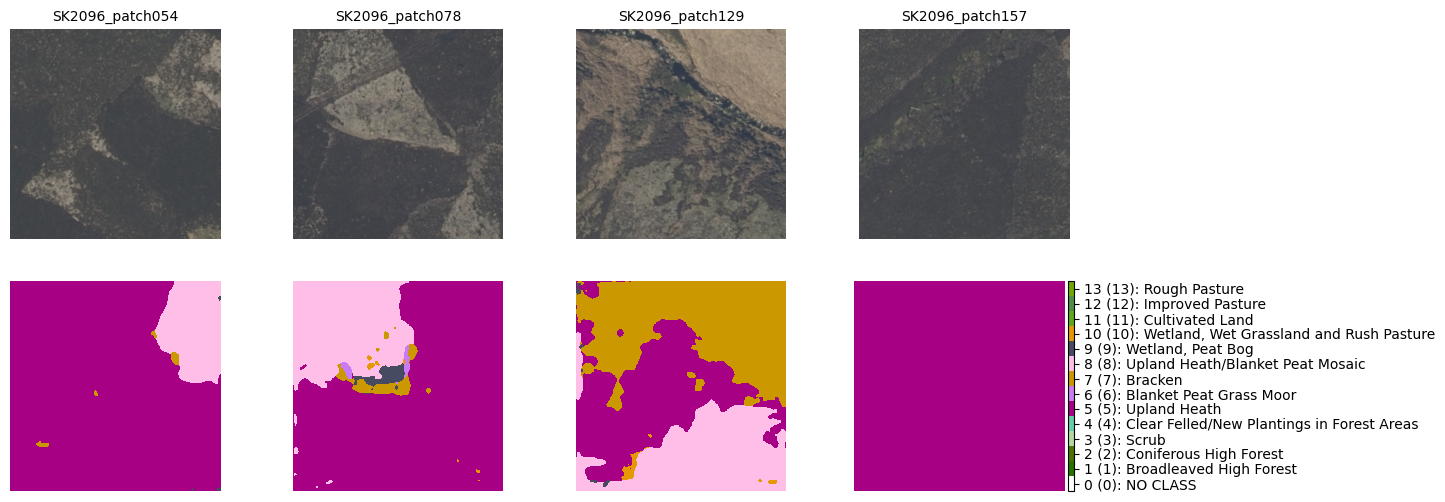

In [184]:
kk += 4
# kk = 0
# key = 'E'
# inds_examples_c = [51] #[12, 20, 66, 77]  # 2, 3, 12, 20, 46, 66, 77
# inds_examples_d = [17, 48, 50 ]  # [7, 19, 27, 44, 50] # [2, 7, 14, 19, 27, 44, 45, 50, 52]
# inds_examples_e = [12, 14, 29, 30, 42]  # [12, 14, 22, 29, 30, 42]
# tmp_batch, names_patches = lcm.get_any_combination_from_ds(ds=test_ds_det[key], list_inds=inds_examples_e)

tmp_batch, names_patches = lcm.get_batch_from_ds(ds=test_ds_det['all'], 
                                                 batch_size=4, start_ind=kk)
# _ = lcm.predict_single_batch_from_testdl_or_batch(model=LCU_det[key], batch=tmp_batch,
#                                          preprocessing_fun=test_ds_det[key].preprocessing_func,
#                                          lc_class_name_list=test_ds_det[key].class_name_list, 
#                                          unique_labels_array=test_ds_det[key].unique_labels_arr,
#                                          names_patches=names_patches)
print(kk)

## C: SK1091_patch051, SK2496_patch029 
## D: SK0686_patch175, SK0790_patch008, SK0790_patch066, patch_SK0790_patch089, SK0987_patch085, SK1588_patch110
## E: SJ9722_patch002, SK0682_patch063, SK1258_patch191, SK1357_patch097
# 

fig, ax = plt.subplots(2, len(names_patches), figsize=(14, 6))
ax_ims = ax[0, :]   
ax_lcs = ax[1, :]

predicted_labels, class_name_list_plot = lcm.two_stage_patch_prediction(model_main=LCU_main, 
                                                                                dict_models_detailed=LCU_det, 
                                            batch_im=tmp_batch[0], dict_class_names_detailed=dict_class_names)


 ## undo preprocessing of image so the true RGB image is shown again:
ims_plot = lca.undo_zscore_single_image(im_ds=tmp_batch[0], f_preprocess=test_ds_det[key].preprocessing_func)
ims_plot = ims_plot.detach().numpy()
for i in range(len(names_patches)):
    ind_ax = i
    lcv.plot_image_simple(im=ims_plot[i, :, :, :], ax=ax_ims[ind_ax])
    lcv.plot_landcover_image(im=predicted_labels[i, :, :], ax=ax_lcs[ind_ax], 
                            lc_class_name_list=class_name_list_plot, 
                            
                            unique_labels_array=test_ds_det[key].unique_labels_arr,
                            plot_colorbar=True if i == len(names_patches) - 1 else False,
                            cax=ax_cbar)
    ax_ims[ind_ax].set_title(names_patches[i])

In [104]:
ind_ax

7

54


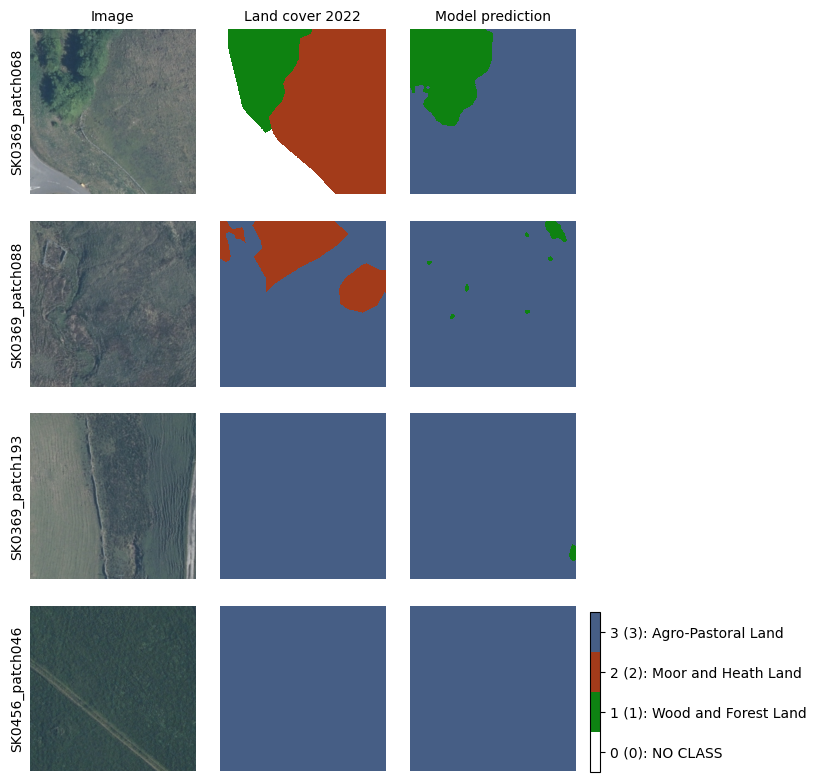

In [129]:
kk += 4
# kk = 50
tmp_batch, names_patches = lcm.get_batch_from_ds(ds=test_ds_main ,
                                                 batch_size=4, start_ind=kk)
_ = lcm.predict_single_batch_from_testdl_or_batch(model=LCU_main, batch=tmp_batch,
                                         preprocessing_fun=test_ds_main.preprocessing_func,
                                         lc_class_name_list=test_ds_main.class_name_list, 
                                         unique_labels_array=test_ds_main.unique_labels_arr,
                                         names_patches=names_patches)
print(kk)

## C: SK1091_patch051, SK2496_patch029 
## D: SK0686_patch175, SK0790_patch008, SK0790_patch066, patch_SK0790_patch089, SK0987_patch085, SK1588_patch110
## E: SJ9722_patch002, SK0682_patch063, SK1258_patch191, SK1357_patch097

## Figure for 1a

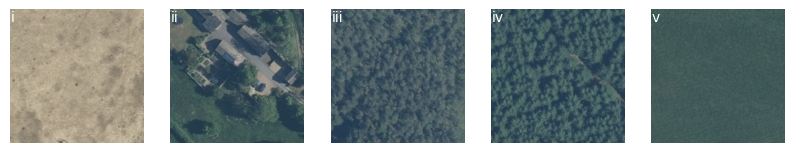

In [12]:
inds_examples = [10, 26, 39, 40, 77]  # either specify the indices or the names
n_examples = len(inds_examples)
fig, ax_ims = plt.subplots(1, n_examples, figsize=(n_examples * 2, 2))
batch, patch_names = lcm.get_any_combination_from_ds(ds=test_ds_main, list_inds=inds_examples)

ims_plot = lca.undo_zscore_single_image(im_ds=batch[0], f_preprocess=test_ds_main.preprocessing_func)
ims_plot = ims_plot.detach().numpy()
for i in range(n_examples):
    lcv.plot_image_simple(im=ims_plot[i, :, :, :], ax=ax_ims[i])
    # lcv.plot_landcover_image(im=predicted_labels[i, :, :], ax=ax_lcs[i], 
    #                         lc_class_name_list=test_ds_main.class_name_list, 
    #                         unique_labels_array=test_ds_main.unique_labels_arr,
    #                         plot_colorbar=True if i == (n_examples - 1) and add_cbar else False, 
    #                         cax=ax_cbar)
    ax_ims[i].text(s=roman_numerics[i], x=2, y=2, ha='left', va='top', c='w')
    

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


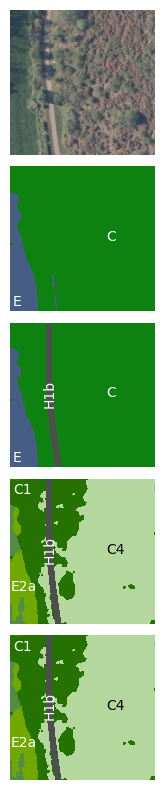

In [29]:
save_fig = True

fig  = plt.figure(figsize=(2, 10), constrained_layout=False)
gs = fig.add_gridspec(5, 1, hspace=0.08, wspace=0.1)
ax_list = [fig.add_subplot(gs[x]) for x in range(5)]


names_examples = ['SK0956_patch108']
key = 'all'
inds_examples = [int(np.where(test_ds_det[key].df_patches['patch_name'] == x)[0][0]) for x in names_examples]
batch, patch_names = lcm.get_any_combination_from_ds(ds=test_ds_det[key], list_inds=inds_examples)
predicted_labels, class_name_list_plot = lcm.two_stage_patch_prediction(model_main=LCU_main, 
                                                                        dict_models_detailed=LCU_det, 
                                    batch_im=batch[0], dict_class_names_detailed=dict_class_names)

predicted_labels_main = LCU_main.forward(batch[0])
predicted_labels_main = lca.change_tensor_to_max_class_prediction(pred=predicted_labels_main)

## undo preprocessing of image so the true RGB image is shown again:
ims_plot = lca.undo_zscore_single_image(im_ds=batch[0], f_preprocess=test_ds_det[key].preprocessing_func)
ims_plot = ims_plot.detach().numpy()

predicted_labels_main = predicted_labels_main[0, :, :]
predicted_labels = predicted_labels[0, :, :]
ax_cbar = None
lcv.plot_image_simple(im=ims_plot[0, :, :, :], ax=ax_list[0])
lcv.plot_landcover_image(im=predicted_labels_main, ax=ax_list[1], 
                        lc_class_name_list=test_ds_main.class_name_list, 
                        unique_labels_array=test_ds_main.unique_labels_arr,
                        plot_colorbar=False, 
                        cax=ax_cbar)
inds_fgh = np.where(cube['class'] == 1)
predicted_labels_main[inds_fgh] = 4
predicted_labels[inds_fgh] = len(class_name_list_plot)
lcv.plot_landcover_image(im=predicted_labels_main, ax=ax_list[2], 
                        lc_class_name_list=test_ds_main.class_name_list + ['Major Transport Routes'], 
                        unique_labels_array=test_ds_main.unique_labels_arr,
                        plot_colorbar=False, 
                        cax=ax_cbar)

lcv.plot_landcover_image(im=predicted_labels, ax=ax_list[3], 
                        lc_class_name_list=class_name_list_plot + ['Major Transport Routes'], 
                        unique_labels_array=test_ds_det[key].unique_labels_arr,
                        plot_colorbar=False, 
                        cax=ax_cbar)
lcv.plot_landcover_image(im=predicted_labels, ax=ax_list[4], 
                        lc_class_name_list=class_name_list_plot + ['Major Transport Routes'], 
                        unique_labels_array=test_ds_det[key].unique_labels_arr,
                        plot_colorbar=False, 
                        cax=ax_cbar)
    

for ii in range(1, 3):
    ax_list[ii].text(s='E', x=10, y=480, ha='left', va='center', zorder=5, c='w')
    ax_list[ii].text(s='C', x=340, y=250, ha='left', va='center', zorder=5, c='w')

for ii in range(2, 5):
    ax_list[ii].text(s='H1b', x=140, y=250, ha='center', va='center', zorder=5, c='w', rotation=90)

for ii in range(3, 5):
    ax_list[ii].text(s='E2a', x=2, y=380, ha='left', va='center', zorder=5, c='w')
    ax_list[ii].text(s='C1', x=10, y=40, ha='left', va='center', zorder=5, c='w')
ax_list[3].text(s='C4', x=340, y=250, ha='left', va='center', zorder=5, c='k')
ax_list[4].text(s='C4', x=340, y=250, ha='left', va='center', zorder=5, c='k')

if save_fig:
    plt.savefig('../figures/fig1a_example_patches_v2.pdf', dpi=300, bbox_inches='tight')

In [17]:
fgh_layer = lca.load_pols('/home/tplas/data/gis/tmp_fgh_layer/tmp_fgh_layer.shp')
tile_outlines = lca.load_pols(path_dict['landscape_character_grid_path'])
tile_outlines = tile_outlines[tile_outlines['PLAN_NO'] == 'SK0956']
# _patch108
## Get fgh that union with tile_outline:
fgh_layer = fgh_layer[fgh_layer['geometry'].intersects(tile_outlines.iloc[0]['geometry'])]
fgh_layer = fgh_layer.reset_index(drop=True)
## For each pol in fgh, only keep part that is within tile_outline:
for i in range(len(fgh_layer)):
    fgh_layer.loc[i, 'geometry'] = fgh_layer.loc[i, 'geometry'].intersection(tile_outlines.iloc[0]['geometry'])

In [18]:
# fgh_layer.plot()
print(tile_outlines['geometry'].total_bounds)
row, col = 0, 0
for ii in range(108):
    col += 1
    if col == 15:
        col = 0
        row += 1
print(row, col)

## Get patch:
xleft = 409000 + (col * 64)
ytop =  357000 - (row * 64)
xright = xleft + 64
ybottom = ytop - 64
patch_pol = shp.geometry.polygon.Polygon([(xleft, ytop), (xright, ytop), (xright, ybottom), (xleft, ybottom)])
df_patchpol = gpd.GeoDataFrame({'geometry': [patch_pol]})

[409000.0036307  355999.99531292 409999.99762129 356999.99906483]
7 3


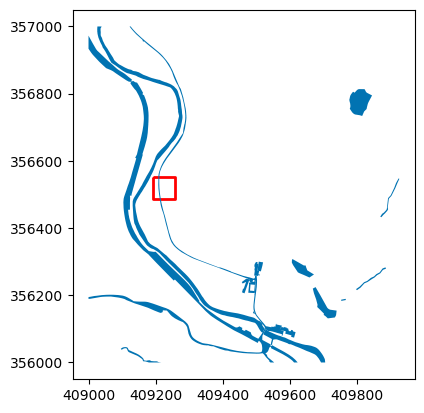

In [19]:
ax = plt.subplot(111)
df_patchpol.plot(ax=ax, color='none', edgecolor='r', linewidth=2)
fgh_layer.plot(ax=ax)

In [20]:
for i in range(len(fgh_layer)):
    fgh_layer.loc[i, 'geometry'] = fgh_layer.loc[i, 'geometry'].intersection(df_patchpol.iloc[0]['geometry'])
## remove all that are mepty
fgh_layer = fgh_layer[fgh_layer['geometry'].area > 0]

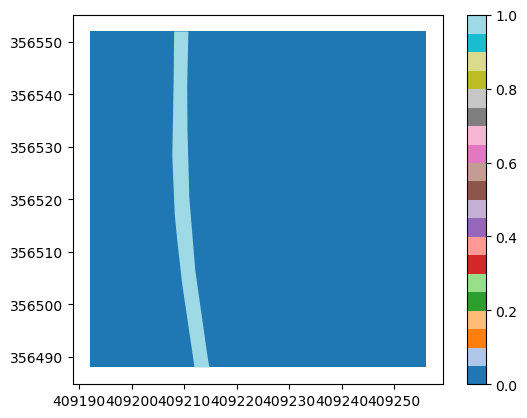

In [21]:
# fgh_layer.plot()
df_patchfgh = gpd.GeoDataFrame({'geometry': [df_patchpol.iloc[0]['geometry'], fgh_layer.iloc[0]['geometry'] ],
                                'class': [0, 1]})
df_patchfgh = df_patchfgh.reset_index(drop=True)

df_patchfgh.plot(column='class', cmap='tab20', legend=True)

In [22]:
cube = make_geocube(df_patchfgh, measurements=['class'],
                        interpolate_na_method=None,
                        # like=ex_tile,  # use resolution of example tiff
                        resolution=(-0.125, 0.125),
                        fill=-1)

# Compute confusion matrix for final detailed predictions
- Load main + 3 detailed LCU models. Assert pre-processing funcs are equal (should be)
- Load test data set, with path_mapping_dict all? (check)
- Use `lcm.two_stage_prediction()` to do predictions for all images in test set 
- Assert that predictions use same class inds as labels (path_mapping_dict)
- (If necessary, relabel either s.t. they use the same labels)
- Use code snippet from `LCU.test_step()` to loop over all test patches and aggregate conf_mat. (Or from just after main class fig)
- Then `lcv.plot_confusion_mat() with model=None and conf_mat=conf_mat`
- Make same fig as for single stage predictions 


In [9]:
model_path_main = 'LCU_2023-04-24-1259.data'  # v2
LCU_main = lcm.load_model(#folder='/media/data-hdd/gis_pd/archive_models/models', 
                          filename=model_path_main)
LCU_main.eval()

path_mapping_dict_main = LCU_main.dict_training_details['path_mapping_dict']
with open(LCU_main.dict_training_details['tile_patch_train_test_split_dict_path'], 'rb') as f:
            dict_tile_patches = pickle.load(f)
            tile_patch_train = dict_tile_patches['train']
            tile_patch_test = dict_tile_patches['test']
            
dir_test_im_patches = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/eval_all_tiles/images_detailed_annotation/'
mask_suffix_test_ds = '_lc_2022_detailed_mask.npy'
     
model_path_det = {'C': 'LCU_2023-04-21-1335.data',
                  'D': 'LCU_2023-04-25-2057.data',
                  'E': 'LCU_2023-04-24-1216.data'}

LCU_det = {}
path_mapping_det = {}
test_ds_det = {}
dict_class_names = {}

test_ds_main = lcm.DataSetPatches(im_dir=dir_test_im_patches, mask_dir=None, 
                            mask_suffix=mask_suffix_test_ds, mask_dir_name='masks_detailed_annotation',
                            preprocessing_func=LCU_main.preprocessing_func, 
                            shuffle_order_patches=False, relabel_masks=True,
                            subsample_patches=False,
                            list_tile_patches_use=tile_patch_test,
                            path_mapping_dict=path_mapping_dict_main)
test_ds_main.remove_no_class_patches()  
dict_class_names['main'] = test_ds_main.class_name_list

for key, val in model_path_det.items():
    LCU_det[key] = lcm.load_model(#folder='/media/data-hdd/gis_pd/archive_models/models/', 
                                  filename=val)
    LCU_det[key].eval()

    with open(LCU_det[key].dict_training_details['tile_patch_train_test_split_dict_path'], 'rb') as f:
                dict_tile_patches_tmp = pickle.load(f)
                tile_patch_test_tmp = dict_tile_patches_tmp['test']
                assert (tile_patch_test == tile_patch_test_tmp), 'Test tiles are not the same for all models!'

    path_mapping_det[key] = LCU_det[key].dict_training_details['path_mapping_dict']
       
    test_ds_det[key] = lcm.DataSetPatches(im_dir=dir_test_im_patches, mask_dir=None, 
                                mask_suffix=mask_suffix_test_ds, mask_dir_name='masks_detailed_annotation',
                                preprocessing_func=LCU_det[key].preprocessing_func, 
                                shuffle_order_patches=False, relabel_masks=True,
                                subsample_patches=False,
                                list_tile_patches_use=tile_patch_test,
                                path_mapping_dict=path_mapping_det[key])
    test_ds_det[key].remove_no_class_patches()
    dict_class_names[key] = test_ds_det[key].class_name_list

## assert all preprocessing funcs are the same:
for key, val in LCU_det.items():
    for tmp_fun in ['mean', 'std']:
        assert (val.preprocessing_func.keywords[tmp_fun] == LCU_main.preprocessing_func.keywords[tmp_fun]), 'Preprocessing functions are not the same for all models!'
# path_mapping_det['all'] = '/home/tplas/repos/cnn-land-cover/content/label_mapping_dicts/label_mapping_dict__identity__2023-04-20-1541.pkl'
path_mapping_det['all'] =  '/home/tplas/repos/cnn-land-cover/content/label_mapping_dicts/label_mapping_dict__all_relevant_subclasses__2023-04-20-1540.pkl'

test_ds_det['all'] = lcm.DataSetPatches(im_dir=dir_test_im_patches, mask_dir=None, 
                                mask_suffix=mask_suffix_test_ds, mask_dir_name='masks_detailed_annotation',
                                preprocessing_func=LCU_main.preprocessing_func, 
                                shuffle_order_patches=False, relabel_masks=True,
                                subsample_patches=False,
                                list_tile_patches_use=tile_patch_test,
                                path_mapping_dict=path_mapping_det['all'])
test_ds_det['all'].remove_no_class_patches()
dict_class_names['all'] = test_ds_det['all'].class_name_list

Loaded LCU_2023-04-24-1259
loss_function is cross_entropy
n_max_epochs is 60
LandCoverUNet class using CrossEntropyLoss()
main_categories_F3inDE_noFGH training using randomly split eval patch data. cross_entropy resnet50 60 epochs
No mask directory provided. Will use masks_detailed_annotation/ in image parent directory instead.
Only using patches that are in tile_patches list (of length 308).
Patches sorted by tile/patch order
Loaded 308 patches
Loaded label_mapping_dict__main_categories_F3inDE_noFGH__2023-04-21-1315.pkl to map labels


100%|██████████| 308/308 [00:01<00:00, 227.91it/s]


Removed 1 patches with no class
Loaded LCU_2023-04-21-1335
loss_function is cross_entropy
n_max_epochs is 60
LandCoverUNet class using CrossEntropyLoss()
C_subclasses_only training using randomly split eval patch data. cross_entropy resnet50 60 epochs
No mask directory provided. Will use masks_detailed_annotation/ in image parent directory instead.
Only using patches that are in tile_patches list (of length 308).
Patches sorted by tile/patch order
Loaded 308 patches
Loaded label_mapping_dict__C_subclasses_only__2023-04-20-1540.pkl to map labels


100%|██████████| 308/308 [00:00<00:00, 317.98it/s]


Removed 186 patches with no class
Loaded LCU_2023-04-25-2057
loss_function is cross_entropy
n_max_epochs is 60
LandCoverUNet class using CrossEntropyLoss()
D_subclasses_only training using randomly split eval patch data. cross_entropy resnet50 60 epochs
No mask directory provided. Will use masks_detailed_annotation/ in image parent directory instead.
Only using patches that are in tile_patches list (of length 308).
Patches sorted by tile/patch order
Loaded 308 patches
Loaded label_mapping_dict__D_subclasses_only__2023-04-20-1540.pkl to map labels


100%|██████████| 308/308 [00:00<00:00, 324.36it/s]


Removed 174 patches with no class
Loaded LCU_2023-04-24-1216
loss_function is cross_entropy
n_max_epochs is 60
LandCoverUNet class using CrossEntropyLoss()
E_subclasses_and_F3d_only training using randomly split eval patch data. cross_entropy resnet50 60 epochs
No mask directory provided. Will use masks_detailed_annotation/ in image parent directory instead.
Only using patches that are in tile_patches list (of length 308).
Patches sorted by tile/patch order
Loaded 308 patches
Loaded label_mapping_dict__E_subclasses_and_F3d_only__2023-04-20-1541.pkl to map labels


100%|██████████| 308/308 [00:00<00:00, 308.12it/s]


Removed 150 patches with no class
No mask directory provided. Will use masks_detailed_annotation/ in image parent directory instead.
Only using patches that are in tile_patches list (of length 308).
Patches sorted by tile/patch order
Loaded 308 patches
Loaded label_mapping_dict__all_relevant_subclasses__2023-04-20-1540.pkl to map labels


100%|██████████| 308/308 [00:01<00:00, 232.53it/s]

Removed 1 patches with no class


### Example plot

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


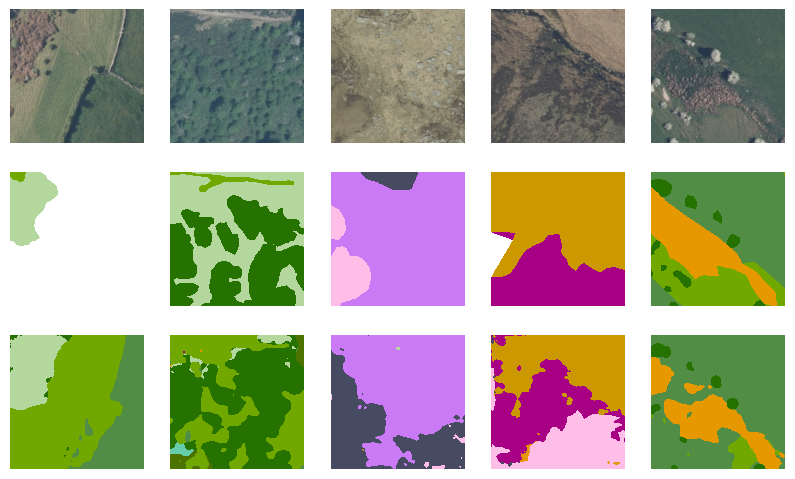

In [10]:
## Example plots:

dict_examples = {'all': [ 'SK0956_patch081', 
                  'SK0879_patch034',
                  'SK0988_patch028', 
                        'SK2096_patch129',
                        'SK0752_patch049']}

fig, ax_all = plt.subplots(3, len(dict_examples['all']), figsize=(10, 6))

for key, names_examples in dict_examples.items():
    inds_examples = [int(np.where(test_ds_det[key].df_patches['patch_name'] == x)[0][0]) for x in names_examples]
    batch, patch_names = lcm.get_any_combination_from_ds(ds=test_ds_det[key], list_inds=inds_examples)
    assert key == 'all'
    predicted_labels, class_name_list_plot = lcm.two_stage_patch_prediction(model_main=LCU_main, 
                                                                            dict_models_detailed=LCU_det, 
                                        batch_im=batch[0], dict_class_names_detailed=dict_class_names)
    ## undo preprocessing of image so the true RGB image is shown again:
    ims_plot = lca.undo_zscore_single_image(im_ds=batch[0], f_preprocess=test_ds_det[key].preprocessing_func)
    ims_plot = ims_plot.detach().numpy()
    transformed_pred_labels = lcm.relabel_twostage_pred_to_testds(class_name_list_twostage=class_name_list_plot,
                                    class_name_list_testds=test_ds_det['all'].class_name_list,
                                    pred_tensor=predicted_labels)
    for i in range(len(inds_examples)):
        ind_ax = i
        lcv.plot_image_simple(im=ims_plot[i, :, :, :], ax=ax_all[0, ind_ax])
        # lcv.plot_landcover_image(im=predicted_labels[i, :, :], ax=ax_all[1, ind_ax], 
        #                         lc_class_name_list=class_name_list_plot, 
        #                         unique_labels_array=test_ds_det[key].unique_labels_arr,
        #                         plot_colorbar=False)

        lcv.plot_landcover_image(im=batch[1][i, :, :], ax=ax_all[1, ind_ax], 
                                lc_class_name_list=test_ds_det['all'].class_name_list, 
                                unique_labels_array=test_ds_det[key].unique_labels_arr,
                                plot_colorbar=False)

        lcv.plot_landcover_image(im=transformed_pred_labels[i, :, :], ax=ax_all[2, ind_ax], 
                                lc_class_name_list=test_ds_det['all'].class_name_list, 
                                unique_labels_array=test_ds_det[key].unique_labels_arr,
                                plot_colorbar=False)

### Compute confusion matrix:

In [11]:
for key, names_examples in dict_examples.items():
    inds_examples = [int(np.where(test_ds_det[key].df_patches['patch_name'] == x)[0][0]) for x in names_examples]
    batch, patch_names = lcm.get_any_combination_from_ds(ds=test_ds_det[key], list_inds=inds_examples)
    if key == 'all':
        predicted_labels, class_name_list_plot = lcm.two_stage_patch_prediction(model_main=LCU_main, 
                                                                                dict_models_detailed=LCU_det, 
                                            batch_im=batch[0], dict_class_names_detailed=dict_class_names)
    else:
        predicted_labels = LCU_det[key].forward(batch[0])
        predicted_labels = lca.change_tensor_to_max_class_prediction(pred=predicted_labels)
        class_name_list_plot = test_ds_det[key].class_name_list
    ## undo preprocessing of image so the true RGB image is shown again:
    ims_plot = lca.undo_zscore_single_image(im_ds=batch[0], f_preprocess=test_ds_det[key].preprocessing_func)
    ims_plot = ims_plot.detach().numpy()
    transformed_pred_labels = lcm.relabel_twostage_pred_to_testds(class_name_list_twostage=class_name_list_plot,
                                    class_name_list_testds=test_ds_det['all'].class_name_list,
                                    pred_tensor=predicted_labels)

/home/tplas/anaconda3/envs/geo/lib/python3.7/site-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


In [12]:
first_class_is_no_class = False

test_dl = torch.utils.data.DataLoader(test_ds_det['all'], batch_size=20, num_workers=16)
n_classes_pred = len(test_ds_det['all'].class_name_list)
test_confusion_mat = np.zeros((n_classes_pred, n_classes_pred), dtype=np.int32)

for batch in tqdm(test_dl):
    predicted_labels, class_name_list_plot = lcm.two_stage_patch_prediction(model_main=LCU_main, 
                                                                            dict_models_detailed=LCU_det, 
                                            batch_im=batch[0], dict_class_names_detailed=dict_class_names)
    transformed_pred_labels = lcm.relabel_twostage_pred_to_testds(class_name_list_twostage=class_name_list_plot,
                                    class_name_list_testds=test_ds_det['all'].class_name_list,
                                    pred_tensor=predicted_labels)
    true_labels = batch[1].detach()#.numpy()
    assert true_labels.shape == transformed_pred_labels.shape
    assert type(true_labels) == torch.Tensor and type(transformed_pred_labels) == torch.Tensor
    ## skip factor ? 

    for ic_true in range(n_classes_pred):
        for ic_pred in range(n_classes_pred):
            n_match = int((transformed_pred_labels[true_labels == ic_true] == ic_pred).sum()) 
            test_confusion_mat[ic_true, ic_pred] += n_match  # just add to existing matrix; so it can be done in batches
    
    if first_class_is_no_class:
        conf_mat_use = test_confusion_mat[1:, 1:]
    else:
        conf_mat_use = test_confusion_mat
    overall_accuracy = conf_mat_use.diagonal().sum() / conf_mat_use.sum() 


  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [05:53<00:00, 22.08s/it]


Removing NO CLASS from confusion matrix


Removing NO CLASS from confusion matrix


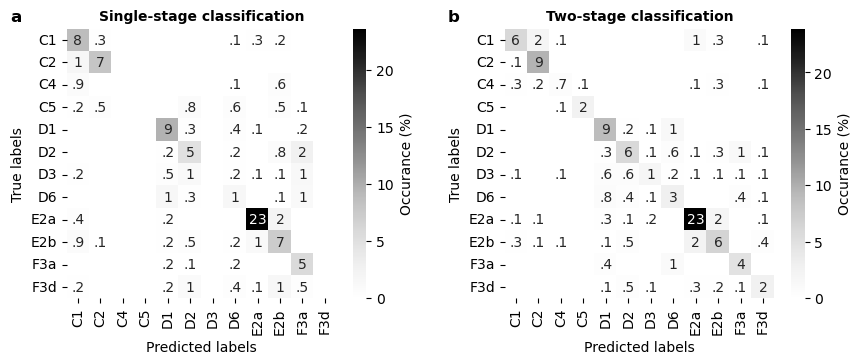

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3.5), gridspec_kw={'wspace': 0.3})
save_fig = True 

results_multi = lcv.plot_confusion_summary(model=None, conf_mat=conf_mat_use, class_name_list=test_ds_det['all'].class_name_list,
                            dict_override_shortcuts={'Scrub': 'C4', 'Upland Heath': 'D1', 'Blanket Peat Grass Moor': 'D2', 
                                                          'Upland Heath/Blanket Peat Mosaic': 'D6'},
                           normalise_hm=True, skip_factor=1, fmt_annot='.1f',
                           print_table=False, ax_hm=ax[1],
                            remove_no_class_if_present=True,
                           print_main_text=False, suppress_zero_annot=True,
                           class_indices_to_remove=[9],
                           title_hm='Two-stage classification')

model_name_single = 'LCU_2023-05-12-1015.data'
LCU_single = lcm.load_model(filename=model_name_single, verbose=0) # reloading necessary for each checkpoint load because checkpoints miss meta info

results_single = lcv.plot_confusion_summary(model=LCU_single, conf_mat=None, class_name_list=LCU_single.dict_training_details['class_name_list'],
                                 dict_override_shortcuts={'Scrub': 'C4', 'Upland Heath': 'D1', 'Blanket Peat Grass Moor': 'D2', 
                                                          'Upland Heath/Blanket Peat Mosaic': 'D6'},
                           normalise_hm=True, skip_factor=1, fmt_annot='.1f',
                           print_table=False, ax_hm=ax[0],
                           print_main_text=False, suppress_zero_annot=True,
                           remove_no_class_if_present=True,
                           class_indices_to_remove=[9],
                           title_hm='Single-stage classification')

for i_plot in range(2):
    ax[i_plot].annotate('a' if i_plot == 0 else 'b', xy=(-0.21, 1.07), xycoords='axes fraction', 
                        weight='bold', fontsize=12, ha='left', va='top')

if save_fig:
    plt.savefig('../figures/fig_both_confusion_matrix.pdf', dpi=300, bbox_inches='tight')

In [69]:
df_single = results_single[0]
df_multi = results_multi[0]
df_single['model'] = 'single'
df_multi['model'] = 'multi'

## concat columns by class name and model
df_concat = df_single.join(df_multi, lsuffix='_single', rsuffix='_multi')
assert df_concat['class name_single'].equals(df_concat['class name_multi'])
df_concat = df_concat.drop(columns=['class name_multi', 'class shortcut_multi', 'model_single', 'model_multi'])
df_concat = df_concat.rename(columns={'class name_single': 'class name', 'class shortcut_single': 'class shortcut'})
df_concat = df_concat.drop(columns=['true density_single', 'true density_multi', 'predicted density_single', 'predicted density_multi'])
df_concat = df_concat.rename(columns={'class shortcut': 'code'})
rename_dict = {'sensitivity_single': 'Sens. SS', 'precision_single': 'Prec. SS',
               'sensitivity_multi': 'Sens. MS', 'precision_multi': 'Prec. MS'} 
df_concat = df_concat.rename(columns=rename_dict)
df_concat
lca.export_df_stats_to_latex(df_stats=df_concat, path_latex='../figures/tables/df_single_multi_comparison.tex',
                             cols_2_decimals = ['Sens. SS', 'Prec. SS', 'Sens. MS', 'Prec. MS'],
                             cols_1_decimal_perc = [])

Index(['class name', 'code', 'Sens. SS', 'Prec. SS', 'Sens. MS', 'Prec. MS'], dtype='object')


,\textbf{Class name},\textbf{Code},\textbf{Sens. SS},\textbf{Prec. SS},\textbf{Sens. MS},\textbf{Prec. MS}
0,Broadleaved High Forest,C1,0.90,0.65,0.62,0.87
1,Coniferous High Forest,C2,0.81,0.89,0.99,0.80
2,Scrub,C4,0.00,nan,0.38,0.61
3,Clear Felled/New Plantings in Forest Areas,C5,0.00,nan,0.95,0.94
4,Upland Heath,D1,0.91,0.75,0.83,0.78
5,Blanket Peat Grass Moor,D2,0.55,0.55,0.67,0.72
6,Bracken,D3,0.00,nan,0.48,0.75
7,Upland Heath/Blanket Peat Mosaic,D6,0.33,0.38,0.63,0.47
8,Improved Pasture,E2a,0.89,0.93,0.90,0.85
9,Rough Pasture,E2b,0.70,0.53,0.62,0.67


Removing NO CLASS from confusion matrix


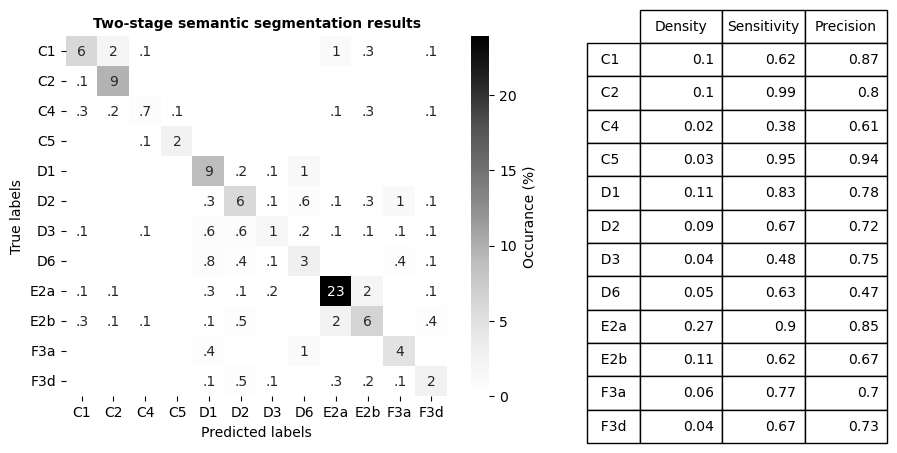

In [16]:
save_fig = False 

_ = lcv.plot_confusion_summary(model=None, conf_mat=conf_mat_use, class_name_list=test_ds_det['all'].class_name_list,
                            dict_override_shortcuts={'Scrub': 'C4', 'Upland Heath': 'D1', 'Blanket Peat Grass Moor': 'D2', 
                                                          'Upland Heath/Blanket Peat Mosaic': 'D6'},
                           normalise_hm=True, skip_factor=1, fmt_annot='.1f',
                            remove_no_class_if_present=True,
                           print_main_text=False, suppress_zero_annot=True,
                           class_indices_to_remove=[9],
                           title_hm='Two-stage semantic segmentation results')


if save_fig:
    plt.savefig('/home/tplas/repos/cnn-land-cover/figures/fig_conf_mat_twostage.pdf', dpi=300, bbox_inches='tight')

Removing NO CLASS from confusion matrix


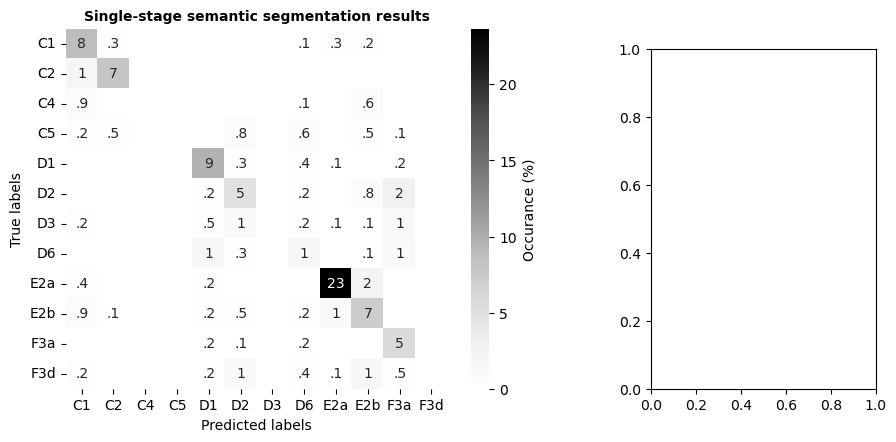

In [8]:
model_name = 'LCU_2023-05-12-1015.data'
save_fig = False 

LCU = lcm.load_model(filename=model_name, verbose=0) # reloading necessary for each checkpoint load because checkpoints miss meta info

tmp = lcv.plot_confusion_summary(model=LCU, conf_mat=None, class_name_list=LCU.dict_training_details['class_name_list'],
                                 dict_override_shortcuts={'Scrub': 'C4', 'Upland Heath': 'D1', 'Blanket Peat Grass Moor': 'D2', 
                                                          'Upland Heath/Blanket Peat Mosaic': 'D6'},
                           normalise_hm=True, skip_factor=1, fmt_annot='.1f',
                           print_table=False,
                           print_main_text=False, suppress_zero_annot=True,
                           remove_no_class_if_present=True,
                           class_indices_to_remove=[9],
                           title_hm='Single-stage semantic segmentation results')

if save_fig:
    plt.savefig('/home/tplas/repos/cnn-land-cover/figures/fig_conf_mat_singlestage.pdf', dpi=300, bbox_inches='tight')

In [4]:
LCU.dict_training_details['class_name_list']

['NO CLASS',
 'Broadleaved High Forest',
 'Coniferous High Forest',
 'Scrub',
 'Clear Felled/New Plantings in Forest Areas',
 'Upland Heath',
 'Blanket Peat Grass Moor',
 'Bracken',
 'Upland Heath/Blanket Peat Mosaic',
 'Cultivated Land',
 'Improved Pasture',
 'Rough Pasture',
 'Wetland, Peat Bog',
 'Wetland, Wet Grassland and Rush Pasture']